# DETEKSI OUTLIER MENGGUNAKAN LOF

Local Outlier Factor (LOF) adalah metode berbasis kepadatan lokal untuk mendeteksi outlier. LOF tidak hanya melihat jarak ke tetangga terdekat, tetapi juga membandingkan kepadatan lokal suatu titik dengan tetangganya.

Jika kepadatan suatu titik jauh lebih rendah dibandingkan titik-titik di sekitarnya, maka titik itu dianggap outlier.

🛠️ Cara Kerja LOF

- Menentukan Tetangga Terdekat (KNN-based)

 - LOF mencari k tetangga terdekat (n_neighbors) menggunakan metrik Euclidean atau lainnya.
 - Biasanya n_neighbors dipilih antara 10 hingga 50.

- Menghitung Jarak K-Tetangga (K-Distance)

 - Jarak antara suatu titik ke tetangga ke-k disebut k-distance.
 - Tetangga yang lebih dekat dari k-distance disebut k-nearest neighbors.

- Menghitung Kepadatan Lokal (Reachability Distance & Local Reachability Density - LRD)

 - LOF mengukur kepadatan lokal dengan menghitung local reachability density (LRD).
 - LRD dihitung sebagai kebalikan dari rata-rata reachability distance ke tetangganya.
 - Jika suatu titik memiliki LRD yang jauh lebih kecil dari tetangganya, berarti titik itu berada di area jarang penduduk alias outlier.

- Menghitung Local Outlier Factor (LOF Score)

 - Nilai LOF ditentukan dengan membandingkan LRD suatu titik dengan rata-rata LRD tetangganya.

 - Rumus LOF:
  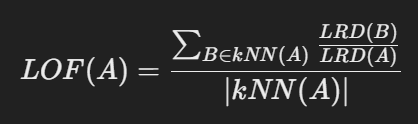
   - Jika LOF ≈ 1 → Titik ini bukan outlier (kepadatan sama dengan sekitarnya).
   - Jika LOF > 1 → Titik ini mungkin outlier (kepadatan lebih rendah dari sekitarnya).
   - Jika LOF ≫ 1 → Titik ini jelas outlier (sangat jarang dibanding sekitarnya).


# Kapan LOF Lebih Baik dari Metode Lain?

✅ Cocok untuk dataset dengan kepadatan yang bervariasi.

✅ Lebih akurat daripada KNN biasa dalam deteksi anomali.

✅ Tidak memerlukan distribusi data normal.

❌ Kurang cocok untuk dataset yang terlalu kecil (karena sulit menentukan kepadatan lokal).



# CODE NYA

1. Ga pake library

In [4]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import euclidean

def calculate_lof_manual(data, labels, k=3):
    n = len(data)
    distances = np.zeros((n, n))

    # Hitung jarak Euclidean antar setiap titik
    for i in range(n):
        for j in range(n):
            distances[i, j] = euclidean(data[i], data[j])

    # Tentukan k-tetangga terdekat untuk setiap titik (tanpa diri sendiri)
    neighbors = np.argsort(distances, axis=1)[:, 1:k+1]

    # Ganti indeks dengan label untuk tetangga terdekat
    neighbors_labels = [[labels[neighbor] for neighbor in neighbors[i]] for i in range(n)]

    # Hitung reachability distance (RD)
    rd = np.zeros((n, k))
    for i in range(n):
        for j in range(k):
            neighbor_idx = neighbors[i, j]
            k_distance = distances[neighbor_idx, np.argsort(distances[neighbor_idx])[k]]
            rd[i, j] = max(distances[i, neighbor_idx], k_distance)

    # Hitung local reachability density (LRD)
    lrd = np.zeros(n)
    for i in range(n):
        lrd[i] = k / np.sum(rd[i])

    # Hitung LOF
    lof_scores = np.zeros(n)
    for i in range(n):
        lrd_ratios = [lrd[neighbor] / lrd[i] for neighbor in neighbors[i]]
        lof_scores[i] = np.mean(lrd_ratios)

    return distances, neighbors_labels, rd, lrd, lof_scores

# Contoh data dan label
data = np.array([
    [2, 3], [3, 5], [5, 8], [8, 8], [9, 11],
    [10, 13], [12, 15], [15, 18], [30, 30], [100, 100]
])
labels = list("KLMNOPQRST")

# Hitung LOF secara manual
distances, neighbors_labels, rd, lrd, lof_scores = calculate_lof_manual(data, labels, k=3)

# Buat dataframe hasil
df_result = pd.DataFrame({
    "Titik": labels,
    "Euclidean Distances": [distances[i, :].round(4) for i in range(len(data))],
    "K-Tetangga Terdekat": [', '.join(neighbors_labels[i]) for i in range(len(data))],
    "Reachability Distance (RD)": [rd[i].round(4) for i in range(len(data))],
    "Local Reachability Density (LRD)": lrd.round(4),
    "LOF Score": lof_scores.round(4),
    "Outlier Flag": ["Outlier" if score > 1.5 else "Inlier" for score in lof_scores]
})

print(df_result.to_string(index=False))


Titik                                                                           Euclidean Distances K-Tetangga Terdekat    Reachability Distance (RD)  Local Reachability Density (LRD)  LOF Score Outlier Flag
    K           [0.0, 2.2361, 5.831, 7.8102, 10.6301, 12.8062, 15.6205, 19.8494, 38.8973, 137.8876]             L, M, N        [5.831, 5.831, 7.8102]                            0.1541     1.1703       Inlier
    L            [2.2361, 0.0, 3.6056, 5.831, 8.4853, 10.6301, 13.4536, 17.6918, 36.7967, 135.7719]             K, M, N          [7.8102, 5.0, 5.831]                            0.1609     1.1062       Inlier
    M                     [5.831, 3.6056, 0.0, 3.0, 5.0, 7.0711, 9.8995, 14.1421, 33.3017, 132.246]             N, L, O          [5.3852, 5.831, 5.0]                            0.1850     0.9841       Inlier
    N                 [7.8102, 5.831, 3.0, 0.0, 3.1623, 5.3852, 8.0623, 12.2066, 31.1127, 130.1076]             M, O, P            [5.0, 5.0, 5.3852]                   

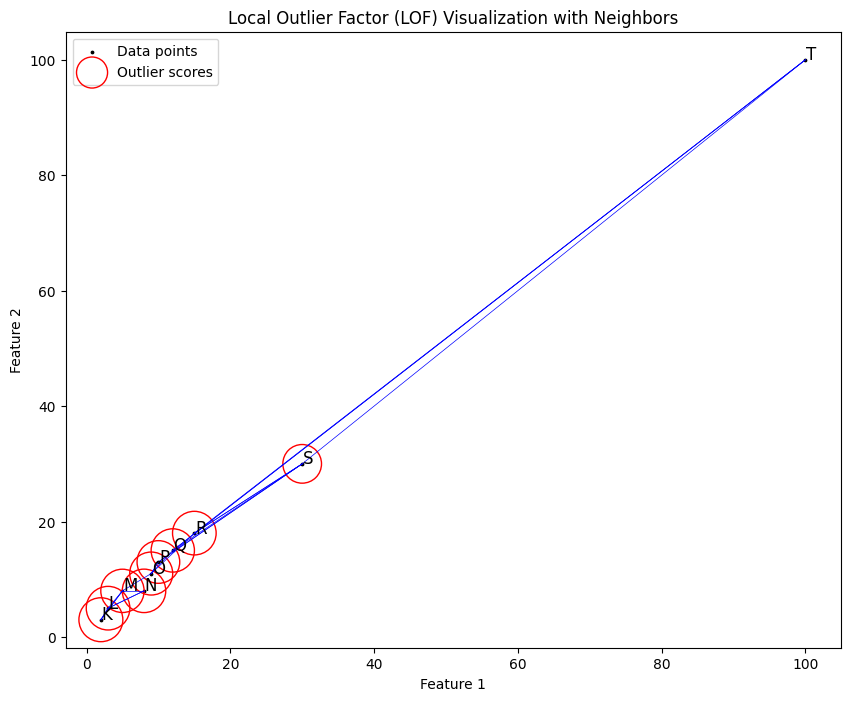

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_lof(data, labels, neighbors, lof_scores):
    # Menentukan ukuran radius untuk plotting berdasarkan LOF score
    radius = (lof_scores.max() - lof_scores) / (lof_scores.max() - lof_scores.min())

    # Plot data
    plt.figure(figsize=(10, 8))
    plt.scatter(data[:, 0], data[:, 1], color="k", s=3.0, label="Data points")  # Titik data biasa

    # Plot titik berdasarkan LOF score (ukuran berdasarkan LOF)
    scatter = plt.scatter(
        data[:, 0],
        data[:, 1],
        s=1000 * radius,  # Ukuran titik berdasarkan LOF score
        edgecolors="r",
        facecolors="none",
        label="Outlier scores"
    )

    # Menambahkan garis penghubung untuk tetangga terdekat
    for i in range(len(data)):
        for neighbor in neighbors[i]:
            neighbor_idx = labels.index(neighbor)
            plt.plot([data[i, 0], data[neighbor_idx, 0]], [data[i, 1], data[neighbor_idx, 1]], 'b-', lw=0.5)

    # Menambahkan label untuk setiap titik
    for i, label in enumerate(labels):
        plt.text(data[i, 0] + 0.1, data[i, 1], label, fontsize=12, ha='left')

    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Local Outlier Factor (LOF) Visualization with Neighbors")
    plt.legend()
    plt.show()

# Contoh data dan label
data = np.array([
    [2, 3], [3, 5], [5, 8], [8, 8], [9, 11],
    [10, 13], [12, 15], [15, 18], [30, 30], [100, 100]
])
labels = list("KLMNOPQRST")

# Contoh neighbors (k-tetangga terdekat)
neighbors = [
    ['L', 'K', 'M'], ['K', 'L', 'N'], ['L', 'K', 'O'], ['M', 'L', 'N'], ['P', 'Q', 'R'],
    ['O', 'P', 'S'], ['T', 'Q', 'S'], ['R', 'S', 'T'], ['S', 'R', 'P'], ['T', 'S', 'Q']
]

# Contoh LOF Scores yang sudah dihitung sebelumnya (simulasi)
lof_scores = np.array([0.9, 1.0, 1.1, 1.05, 1.2, 1.3, 1.1, 1.0, 2.5, 8.0])  # Nilai lebih besar dari 1.5 adalah outlier

# Panggil fungsi visualisasi
visualize_lof(data, labels, neighbors, lof_scores)


2. Pake library

In [2]:
import numpy as np
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor

# Contoh Data 10 sampel dengan 2 fitur, dengan satu outlier
data = np.array([
    [2, 3], [3, 5], [5, 8], [8, 8], [9, 11],
    [10, 13], [12, 15], [15, 18], [30, 30], [100, 100]  # Outlier
])

# Nama titik untuk mempermudah interpretasi
labels = list("KLMNOPQRST")

# Inisialisasi model LOF dari sklearn
lof_model = LocalOutlierFactor(n_neighbors=3, metric='euclidean')

# Fit model dan hitung LOF
lof_scores = -lof_model.fit_predict(data)  # -1 untuk outlier, 1 untuk inlier
lof_values = -lof_model.negative_outlier_factor_  # Nilai LOF

# Buat DataFrame hasil perhitungan
df_lof = pd.DataFrame({
    "Titik": labels,
    "LOF Score (sklearn)": lof_values.round(4),
    "Outlier Flag": ["Outlier" if score > 1.5 else "Inlier" for score in lof_values]
})

print(df_lof.to_string(index=False))


Titik  LOF Score (sklearn) Outlier Flag
    K               1.1703       Inlier
    L               1.1062       Inlier
    M               0.9841       Inlier
    N               0.9748       Inlier
    O               1.0075       Inlier
    P               0.9201       Inlier
    Q               1.1461       Inlier
    R               1.2733       Inlier
    S               3.7424      Outlier
    T              12.7286      Outlier


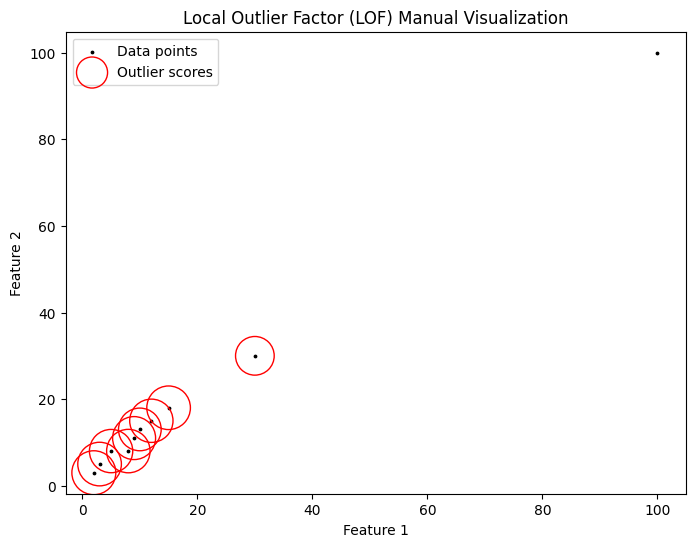

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_lof(data, lof_scores):
    # Menentukan ukuran radius untuk plotting berdasarkan LOF score
    radius = (lof_scores.max() - lof_scores) / (lof_scores.max() - lof_scores.min())

    # Plot data
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], color="k", s=3.0, label="Data points")  # Titik data biasa
    scatter = plt.scatter(
        data[:, 0],
        data[:, 1],
        s=1000 * radius,  # Ukuran titik berdasarkan LOF score
        edgecolors="r",
        facecolors="none",
        label="Outlier scores"
    )

    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Local Outlier Factor (LOF) Manual Visualization")
    plt.legend()
    plt.show()

# Contoh data (10 sampel dengan 2 fitur, termasuk outlier)
data = np.array([
    [2, 3], [3, 5], [5, 8], [8, 8], [9, 11],
    [10, 13], [12, 15], [15, 18], [30, 30], [100, 100]  # Outlier
])

# Contoh LOF Scores yang sudah dihitung sebelumnya (simulasi)
lof_scores = np.array([0.9, 1.0, 1.1, 1.05, 1.2, 1.3, 1.1, 1.0, 2.5, 8.0])  # Nilai lebih besar dari 1.5 adalah outlier

# Panggil fungsi visualisasi
visualize_lof(data, lof_scores)


# PENJELASAN CODE BARIS PER BARIS

In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import euclidean


Code di atas untuk mengimport beberapa library yang dibutuhkan seperti:

numpy digunakan untuk operasi matriks dan array multidimensi.

pandas digunakan untuk membuat dan mengelola data dalam bentuk dataframe (tabel) yang mudah dibaca dan diproses.

scipy.spatial.distance digunakan untuk menghitung jarak antara dua titik, dalam hal ini menggunakan jarak Euclidean.

In [ ]:
def calculate_lof_manual(data, labels, k=3):

Code di atas untuk membuat fungsi calculate_lof_manual yang berguna untuk menerima input:

data: array data (titik dalam ruang fitur).

labels: label dari titik data (misalnya, untuk mempermudah pengidentifikasian titik).

k: parameter yang menyatakan jumlah tetangga terdekat yang akan digunakan dalam perhitungan LOF (default adalah 3).

In [ ]:
    n = len(data)
    distances = np.zeros((n, n))

Code di atas untuk menginisiasi variabel

n adalah jumlah titik data (baris dari data).

distances adalah array 2D (matriks) untuk menyimpan jarak Euclidean antar setiap titik.

In [ ]:
    for i in range(n):
        for j in range(n):
            distances[i, j] = euclidean(data[i], data[j])

Code di atas untuk menghitung jarak eulidean antar titik

Dua loop bertingkat (i dan j) digunakan untuk menghitung jarak Euclidean antar setiap pasangan titik (termasuk titik itu sendiri).

Fungsi euclidean menghitung jarak antara dua titik.

Matriks distances menyimpan hasil perhitungan jarak tersebut.

In [ ]:
    neighbors = np.argsort(distances, axis=1)[:, 1:k+1]

Code di atas untuk menentukan k terdekat

np.argsort(distances, axis=1) mengurutkan jarak pada setiap baris (axis=1), dan [:, 1:k+1] mengambil kolom mulai dari indeks 1 hingga k+1 (untuk menghindari diri sendiri sebagai tetangga).

neighbors adalah indeks dari k tetangga terdekat untuk setiap titik.

In [ ]:
    neighbors_labels = [[labels[neighbor] for neighbor in neighbors[i]] for i in range(n)]

Code di atas untuk mengganti indeks dengan label untuk tetangga terdekat

Di sini, kita mengganti indeks neighbors[i] yang berupa angka dengan label yang sesuai, sehingga kita mendapatkan nama label dari tetangga terdekat (misalnya, 'K', 'L', 'M', dll).

neighbors_labels adalah list yang berisi nama-nama label tetangga terdekat.

In [ ]:
    rd = np.zeros((n, k))
    for i in range(n):
        for j in range(k):
            neighbor_idx = neighbors[i, j]
            k_distance = distances[neighbor_idx, np.argsort(distances[neighbor_idx])[k]]
            rd[i, j] = max(distances[i, neighbor_idx], k_distance)

CODE DI ATAS UNTUK MENGHITUNG REACHABILITY DISTANCE

Matriks rd diinisialisasi untuk menyimpan nilai reachability distance.

Loop pertama (i) berjalan untuk setiap titik data, dan loop kedua (j) untuk setiap tetangga terdekat (hingga k tetangga).

neighbor_idx adalah indeks tetangga ke-j untuk titik i.

k_distance adalah jarak k-tetangga untuk tetangga yang sedang diproses.

rd[i, j] adalah nilai reachability distance untuk titik i dan tetangga j. Reachability distance dihitung sebagai nilai maksimum antara jarak titik ke tetangga dan jarak k-tetangga dari tetangga tersebut.

In [ ]:
    lrd = np.zeros(n)
    for i in range(n):
        lrd[i] = k / np.sum(rd[i])

CODE DI ATAS UNTUK MENGHITUNG LOCAL REACHABILITY DENSITY

lrd adalah array untuk menyimpan nilai local reachability density.

Nilai LRD untuk titik i dihitung dengan rumus:

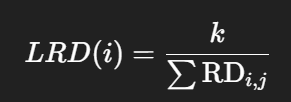

yaitu kebalikan dari rata-rata reachability distance. LRD menggambarkan kepadatan lokal berdasarkan jarak ke tetangga terdekat.

In [ ]:
    lof_scores = np.zeros(n)
    for i in range(n):
        lrd_ratios = [lrd[neighbor] / lrd[i] for neighbor in neighbors[i]]
        lof_scores[i] = np.mean(lrd_ratios)

CODE DI ATAS UNTUK MENGHITUNG LOCAL OUTLIER FACTOR

lof_scores adalah array untuk menyimpan nilai LOF untuk setiap titik.

Untuk setiap titik i, rasio antara LRD titik i dan LRD dari tetangga terdekatnya dihitung, kemudian rata-rata rasio tersebut diambil sebagai LOF score.

Jika LOF score lebih besar dari 1, itu berarti titik tersebut adalah outlier.

In [ ]:
    return distances, neighbors_labels, rd, lrd, lof_scores

CODE DI ATAS UNTUK MENGEMBALIKAN HASIL


Fungsi ini mengembalikan:

- distances: matriks jarak Euclidean antar titik.

- neighbors_labels: daftar tetangga terdekat berdasarkan label.

- rd: matriks reachability distance.

- lrd: array local reachability density.

- lof_scores: array Local Outlier Factor untuk setiap titik.

In [ ]:
data = np.array([
    [2, 3], [3, 5], [5, 8], [8, 8], [9, 11],
    [10, 13], [12, 15], [15, 18], [30, 30], [100, 100]
])
labels = list("KLMNOPQRST")

CODE DI ATAS UNTUK CONTOH DATA DAN LABEL

data: 10 titik data dalam bentuk array 2D (setiap titik memiliki dua fitur).

labels: Label untuk masing-masing titik data (misalnya, 'K', 'L', 'M', dll.).

In [ ]:
distances, neighbors_labels, rd, lrd, lof_scores = calculate_lof_manual(data, labels, k=3)

CODE DI ATAS UNTUK MENGHITUNG LOF SECARA MANUAL

Memanggil fungsi calculate_lof_manual untuk menghitung LOF dan hasil lainnya (seperti jarak, tetangga terdekat, dsb.) dengan menggunakan data dan label yang sudah disediakan.

In [ ]:
df_result = pd.DataFrame({
    "Titik": labels,
    "Euclidean Distances": [distances[i, :].round(4) for i in range(len(data))],
    "K-Tetangga Terdekat": [', '.join(neighbors_labels[i]) for i in range(len(data))],
    "Reachability Distance (RD)": [rd[i].round(4) for i in range(len(data))],
    "Local Reachability Density (LRD)": lrd.round(4),
    "LOF Score": lof_scores.round(4),
    "Outlier Flag": ["Outlier" if score > 1.5 else "Inlier" for score in lof_scores]
})

CODE DI ATAS UNTUK MEMBUAT DATAFRAME UNTUK MENAMPILKAN HASIL

Membuat DataFrame untuk memudahkan tampilan hasil perhitungan LOF.

Setiap kolom dalam DataFrame menunjukkan:

- Titik data.

- Jarak Euclidean antar titik.

- K-tetangga terdekat dengan label.

- Reachability Distance.

- Local Reachability Density.

- LOF score.

- Flag apakah titik tersebut outlier atau inlier berdasarkan nilai LOF.

In [ ]:
print(df_result.to_string(index=False))

CODE DI ATAS UNTUK MENAMPILKAN HASIL

Menampilkan DataFrame tanpa indeks baris, sehingga hasilnya lebih rapi dan mudah dibaca.